# Clustering

Clustering is a form of [*unsupervised learning*](https://www.wikiwand.com/en/Unsupervised_learning). Broadly speaking, the goal of unsupervised learning is to understand the distribution $P(X_1, \dots, X_n)$ of our data. This is in contrast to *supervised learning* where the goal is to know conditional distributions such as $P(Y | X_1, \dots, X_n)$. With clustering our goal is to find clusters of observations. The idea that each member of a cluster to the rest of the members, and each cluster is different from the other clusters. Usually we can then "look" at each cluster and guess what kind of observations it contains. This can be used in various fields, for example what types of users visit a web platform such as Netflix. Viewers won't have a label "I like action movies" or "I love romantic comedies" but through clustering we might see common viewing patterns appear.

The different approaches to perform clustering are

- Connectivity-based clustering where observations are recursively linked together
- Centroid-based clustering where clusters are represented by a centroid
- Distribution-based clustering where clusters are assumed to be sampled from statistical well-known distributions
- Density-based clustering where dense regions of points are grouped together

Clustering can be fun because you can visualise it if you're only using up to 3 dimensions. Keep in mind that many clustering algorithms work with distance/similarity measures, so the [curse of dimensionality](https://www.wikiwand.com/en/Curse_of_dimensionality) applies! And don't forget to normalize your data :).

For more perspective see [here](http://scikit-learn.org/stable/modules/clustering.html).

In [1]:
# This doesn't work with Jupyter Lab (as of October 2018), please use Jupyter Notebook
%matplotlib notebook  

## K-means

[K-means clustering](https://www.wikiwand.com/en/K-means_clustering) is one of the simpler clustering algorithms. The idea is that we want to represent each cluster by a vector who's coordinates are obtained by averaging the coordinates of observations that belong to it. An observations belongs to the cluster that is closest to. The "closest to" part depends on a metric provided by the user. This is a bit of a [chicken or the egg](https://www.wikiwand.com/en/Chicken_or_the_egg) kind of problem. On the one hand we want to know to which cluster each observation belongs to. On the other hand the position of each cluster depends on the observations that are assigned to it. We'll get back to this.

First let's prepare the classic iris dataset.

In [2]:
import pandas as pd
from sklearn import datasets

X, y = datasets.load_iris(return_X_y=True)
X = pd.DataFrame(data=X, columns=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])

X.head()

,Sepal length,Sepal width,Petal length,Petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


<IPython.core.display.Javascript object>


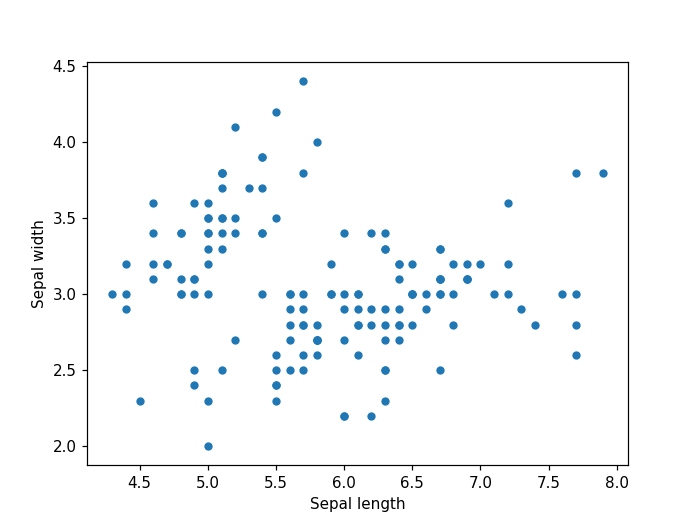

In [3]:
X.plot.scatter(x='Sepal length', y='Sepal width');

### Explanation

It turns that finding the solution to the K-means method is [NP-hard](https://www.wikiwand.com/en/NP-hardness) (see this [ELI5](https://www.reddit.com/r/explainlikeimfive/comments/1glcly/eli5_np_nphard_npcomplete/) for some intuition). This doesn't mean we can't find an approximate (and good enough) solution. The most popular approximate method is [Lloyd's algorithm](https://www.wikiwand.com/en/Lloyd%27s_algorithm), and it isn't just used for K-means.

Lloyd's algorithm goes as follows:

1. Generate random centroids (a fancy name for the center of each cluster) 
2. Assign each observation to the closest centroid.
3. Move each centroid to the average of the observations that are assigned to it.
4. Repeat from step 2 until a termination criterion is reached.

Usually the termination criterion is simply a number of iterations provided by the user. Fancy implementations stop the algorithm once some convergence has been detected.

### With scikit-learn

You can find the documentation for scikit-learn's implementation of K-means [here](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Try and play around with the parameters. You can also use different variables of the iris dataset.

<IPython.core.display.Javascript object>


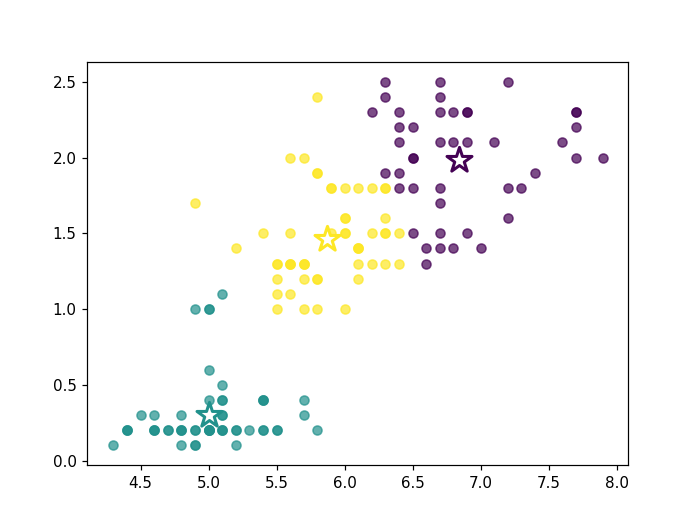

In [8]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster


columns = ['Sepal length', 'Petal width']

k = 3 
kmeans = cluster.KMeans(n_clusters=k, random_state=42)
kmeans.fit(X[columns])

centroids = kmeans.cluster_centers_
labels = kmeans.labels_ 

fig, ax = plt.subplots()
colors = iter(cm.viridis(np.linspace(0, 1, k)))

for i, centroid in enumerate(centroids):
    color = next(colors)
    
    # Plot the points
    x = [xi[0] for xi in X[columns][labels == i].values]
    y = [xi[1] for xi in X[columns][labels == i].values]
    ax.scatter(x, y, color=color, alpha=0.7)
    
    # Plot the centroids
    ax.scatter(centroid[0], centroid[1], color='white', marker='*', s=300,
               edgecolor=color, linewidth='2')
    

In [6]:
centroid

array([5.86730769, 1.46538462])

The big question is how do we choose $k$? We can usually take a good guess if we can visualize the data, but that is almost never the case in practice. What we need is a metric. The idea is that we want to loop over a range of $k$ values and measure the quality of our clusters. Obviously "quality" is subject to interpretation. A commonly used metric is called the [silhouette](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) where the best possible score is 1 and the worst is -1.

In [5]:
from sklearn import metrics


for k in [2, 3, 4, 5, 6]:
    
    k_means = cluster.KMeans(n_clusters=k, random_state=42)
    
    labels = k_means.fit_predict(X)
    
    silhouette = metrics.silhouette_score(X, labels)
    
    print('k = {} gives a silhouette score of {}'.format(k, silhouette))

k = 2 gives a silhouette score of 0.681046169211746
k = 3 gives a silhouette score of 0.5528190123564091
k = 4 gives a silhouette score of 0.4980505049972867
k = 5 gives a silhouette score of 0.4887488870931048
k = 6 gives a silhouette score of 0.3648340039670018


### Let's code it ourselves

Let's write a simple version of Lloyd's algorithm. For the fun of it we'll plot the progress of the algorithm.

<IPython.core.display.Javascript object>


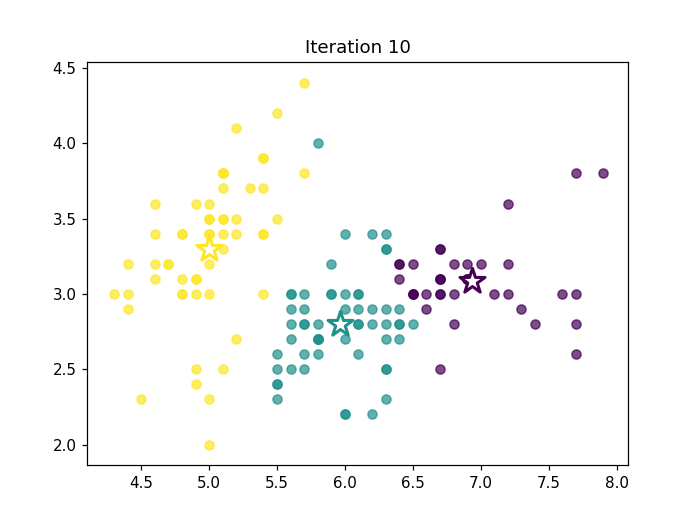

In [6]:
import time

import numpy as np


def l1_distance(x, y):
    return np.abs(x - y).sum()


def k_means(X, k=3, distance=l1_distance, n_iterations=10, ax=None):
    
    # Make sure we're working with a numpy.ndarray and not a pandas.DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # Create the initial centroids at random
    row_means = X.mean(axis=0)
    centroids = [np.random.uniform(0.5, 1.5, size=len(row_means)) * row_means for _ in range(k)]
    
    for i in range(n_iterations):
        
        # We'll store the clusters inside a dictionary
        clusters = {i: [] for i in range(k)}
        
        # Iterate over each data point 
        for j, x in enumerate(X):
            
            # Compute the distance with each centroid
            distances = [distance(x, centroid) for centroid in centroids]
            
            # Find the closest centroid
            closest = np.argmin(distances)
            clusters[closest].append(j)
    
        # Update each centroid
        for j, points in clusters.items():
            
            # No update is needed if there are no points assigned
            if not points:
                continue
            
            # The centroid becomes the average of the points in the clusters it forms 
            centroid = np.mean([X[k] for k in points], axis=0)
            centroids[j] = centroid
    
        # Plot the current disposition
        if ax:
            colors = iter(cm.viridis(np.linspace(0, 1, k)))
            ax.clear()
            ax.set_title('Iteration {}'.format(i+1))
            
            for i, centroid in enumerate(centroids):
                
                # Use the same color for the point and the centroids
                color = next(colors)
                
                # Plot the points belonging to the centroid
                cluster = clusters[i]
                x = [X[j][0] for j in cluster]
                y = [X[j][1] for j in cluster]
                ax.scatter(x, y, color=color, alpha=0.7)
                
                # Plot the centroid
                ax.scatter(centroid[0], centroid[1], color='white', marker='*', s=300,
                           edgecolor=color, linewidth='2')
            
            fig.canvas.draw()
            time.sleep(0.3)
        
    return centroids, clusters


fig, ax = plt.subplots()
plt.ion()
    
centroids, clusters = k_means(X[['Sepal length', 'Sepal width']], k=3, ax=ax)

## Hierarchical clustering

### Explanation

There are two types of hierarchical clustering:

- Agglomerative where we start with one cluster per observation and merge recursively
- Divisive where we start with one cluster and break it down recursively

There are two components:

1. A metric which calculates a distance between two points.
2. A linkage criterion which computes a distance between two clusters given their pair-wise distances obtained with the metric.

Some simple linkage criteria are:

- Maximum linkage: $max\{d(a, b); a \in A\, b \in B\}$
- Minimum linkage: $min\{d(a, b); a \in A\, b \in B\}$
- Average linkage: $\frac{1}{|A| \times |B|} \sum_{a \in A} \sum_{b \in B} d(a, b)$

You can find more linkage criteria [here](https://www.wikiwand.com/en/Hierarchical_clustering#/Linkage_criteria).

### With scipy

See [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).

In [10]:
url = 'https://python-graph-gallery.com/wp-content/uploads/mtcars.csv'
df = pd.read_csv(url).set_index('model')

df.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
model,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


<IPython.core.display.Javascript object>


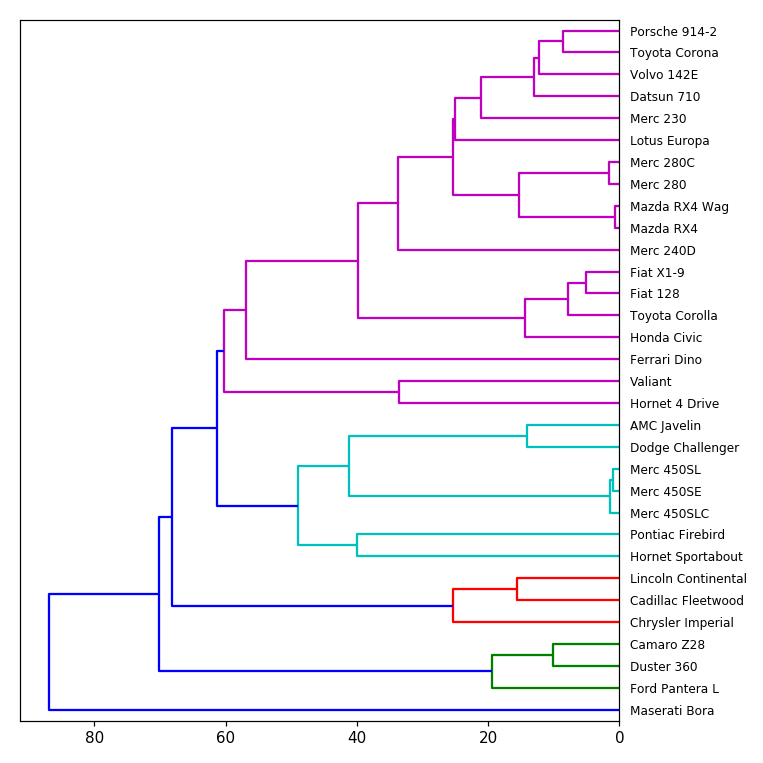

In [11]:
from scipy.cluster import hierarchy


linkage = hierarchy.linkage(df, 'single')

fig = plt.figure(figsize=(7, 7))
hierarchy.dendrogram(linkage, labels=df.index, orientation='left')
plt.tight_layout();
plt.show();

### Let's code it ourselves

<IPython.core.display.Javascript object>


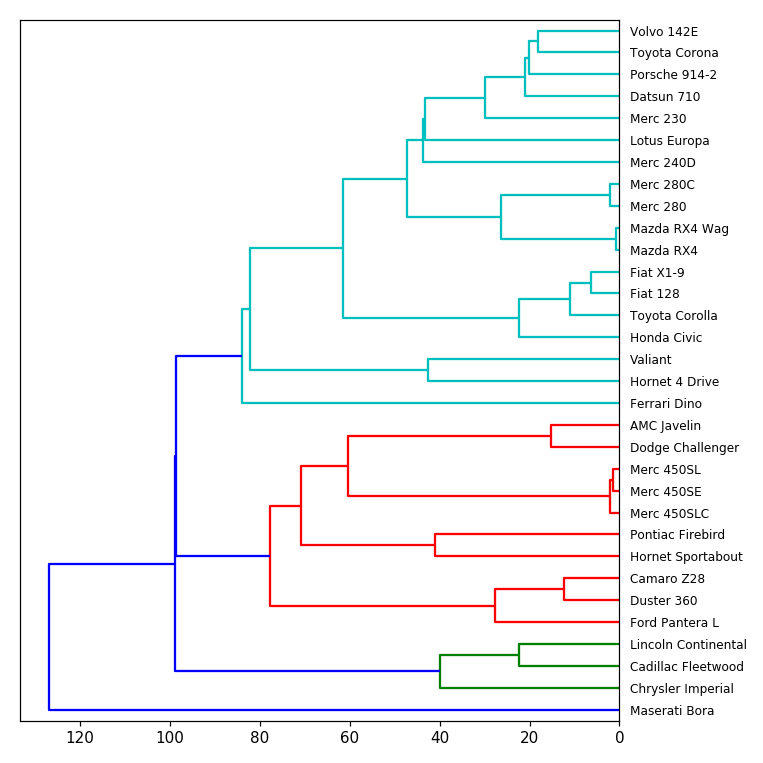

In [12]:
import itertools


def hac(X, metric=l1_distance):
    """HAC stands for Hierarchical Agglomerative Clustering.
    
    In this implementation we use minimum linkage criterion.
    """
    
    # Make sure we're working with a numpy.ndarray and not a pandas.DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # We will store the clusters in a dictionary of lists
    clusters = {i: [i] for i, _ in enumerate(X)}
    
    # We will also store the linkage history for plotting purposes
    linkage = []
    
    # Compute each pairwise distance
    n = len(clusters)
    distances = np.zeros(shape=(n, n)) + np.inf
    for i in range(n):
        for j in range(i+1, n):
            dist = metric(X[i], X[j])
            distances[i, j] = dist
            distances[j, i] = dist
            
    while len(clusters) > 1:
        
        # We're looking for the two closest clusters, denoted a and b
        a, b = None, None
        min_dist = np.inf
        
        for i, j in itertools.combinations(clusters.keys(), 2):
                
            # Search for the smallest pairwise between both clusters
            dist = min(metric(X[k], X[l]) for k in clusters[i] for l in clusters[j])

            # Check if the smallest distance is lower than the current lowest distance
            if dist < min_dist:
                a, b = i, j
                min_dist = dist
        
        # Merge the two closest clusters
        clusters[n] = clusters.pop(a) + clusters.pop(b)
                
        # Update the linkage matrix
        linkage.append([a, b, min_dist, len(clusters[n])])
        
        n += 1
        
    return linkage
    
linkage = hac(df)

fig = plt.figure(figsize=(7, 7))
hierarchy.dendrogram(linkage, labels=df.index, orientation='left')
plt.tight_layout();
plt.show();